In [202]:
%run spot_functions.ipynb
%run gl_functions.ipynb

In [203]:
# sdk, robot, id_client, \
# robot_state_client, command_client, \
# image_client, graph_nav_client, \
# world_object_client, manipulation_api_client = initRobot('192.168.50.3')
# timeout_sec = 5

In [6]:
lease_client, lease, lease_keep_alive = getLease(robot)

In [7]:
# Initialize Groundlight API

GROUNDLIGHT_API_TOKEN = 'api_2Au8NPiTMbSLQ73Vjr2eMhX2qUh_pt4EEKhtDNgnjN3dUAr89YANDcYsmBkJZV'
gl = Groundlight(api_token=GROUNDLIGHT_API_TOKEN)
detectors = gl.list_detectors()
det = detectors.results[1]
print(det)

id='det_2AuDZFz06xbytjWrTL0dUvsjOz7' type=<DetectorTypeEnum.detector: 'detector'> created_at=datetime.datetime(2022, 6, 21, 15, 30, 29, 961429, tzinfo=tzoffset(None, -25200)) name='newRubiksCube' query="Is entire Rubik's cube contained within image?" group_name='__DEFAULT' confidence_threshold=0.5


In [201]:
getBattInfo()

Battery at: 17.0 %. Robot has 995 seconds left


(17.0, 995)

In [194]:
success = powerOn(robot)

True


In [196]:
bdcrc.blocking_selfright(command_client, timeout_sec = timeout_sec)

[ 0.64 -0.12  0.54] [ 0.82 -0.17 -0.6 ]


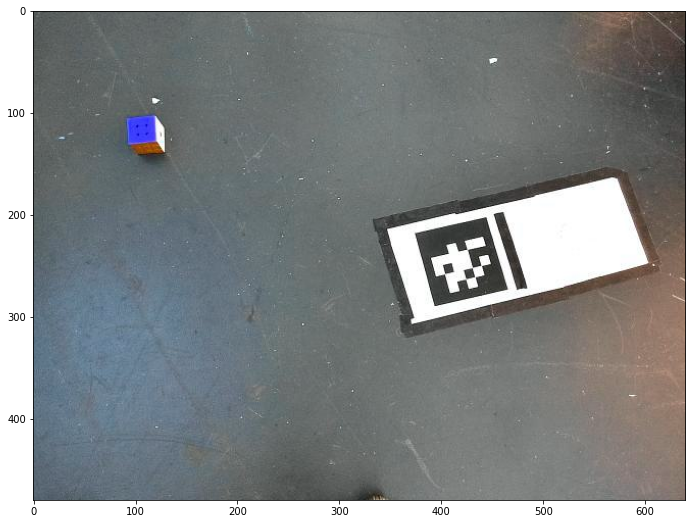

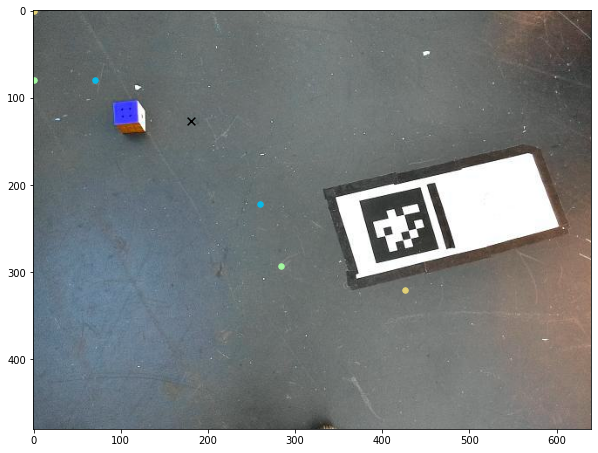

Current state:  MANIP_STATE_ATTEMPTING_RAYCASTING
Current state:  MANIP_STATE_WALKING_TO_OBJECT
Current state:  MANIP_STATE_WALKING_TO_OBJECT
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP

KeyboardInterrupt: 

In [199]:
for i in range(1):
    bdcrc.blocking_stand(command_client, timeout_sec = timeout_sec)

    moveTo = [np.random.uniform(0.6, 0.9), 
              np.random.uniform(-0.3, 0.3), 
              np.random.uniform(0.5, 0.8)]
    lookAt = [np.random.uniform(0.5, 1.5), 
              np.random.uniform(-0.7,0.7), 
              np.random.uniform(-0.5,-2)]
    print(np.round(moveTo, 2), np.round(lookAt,2))
    
    moveToAndLookAt(moveTo,lookAt, True)
    cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
    time.sleep(0.5)

    response = graph_nav_client.clear_graph()

    imgName = 'GLIMG/handColorImage.jpg'
    image_response = capImage(image_client, imgName)
    img = cv2.imread(imgName)
    plt.figure(figsize = (12,9))
    plt.imshow(img)

    tree = sweepLocalize(det, img)

    if tree is None:
        print('CUBE NOT FOUND')
        continue

    plotTreeOnImage(tree, img)
    plt.show()

    pxLoc = assemblePxTree(tree)
    pick_vec = geometry_pb2.Vec2(x=pxLoc[0], y=pxLoc[1])

    grasp = manipulation_api_pb2.PickObjectInImage(
        pixel_xy=pick_vec, transforms_snapshot_for_camera=image_response.shot.transforms_snapshot,
        frame_name_image_sensor=image_response.shot.frame_name_image_sensor,
        camera_model=image_response.source.pinhole)

    grasp_request = manipulation_api_pb2.ManipulationApiRequest(pick_object_in_image=grasp)
    
    makeGrasp(grasp_request, graph_nav_client)
    
    cmd = RobotCommandBuilder.arm_stow_command()
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)
    

In [180]:

bdcrc.blocking_stand(command_client, timeout_sec = timeout_sec)

In [170]:
#moveRobotRelative(command_client, -0.3, 0.2, 0)

In [173]:
moveTo = [np.random.uniform(0.6, 1), 
          np.random.uniform(-0.3, 0.3), 
          np.random.uniform(-0.2, 0.8)]

lookAt = [np.random.uniform(0.5, 1.5), 
          np.random.uniform(-1,1), 
          np.random.uniform(-0.5,-2)]

print(np.round(moveTo, 2), np.round(lookAt,2))

[0.62 0.1  0.47] [ 0.71 -0.74 -0.97]


ARM already at desired location and orientation


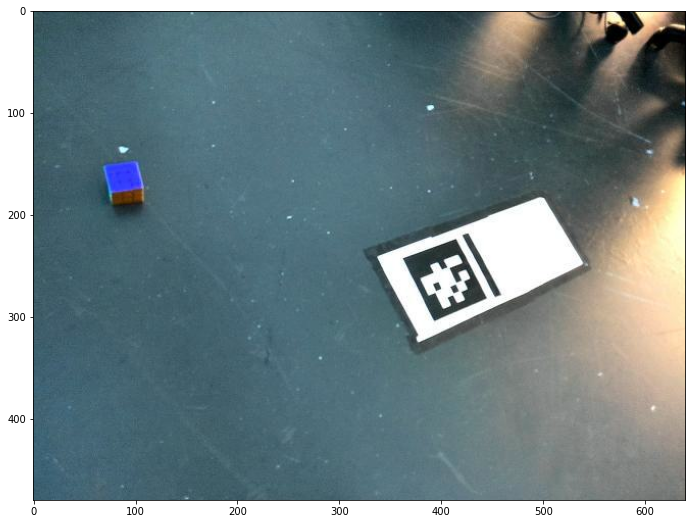

In [175]:
moveToAndLookAt(moveTo,lookAt, True)


cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)
time.sleep(0.5)

response = graph_nav_client.clear_graph()

imgName = 'GLIMG/handColorImage.jpg'
image_response = capImage(image_client, imgName)
img = cv2.imread(imgName)
plt.figure(figsize = (12,9))
plt.imshow(img)

In [176]:
tree = sweepLocalize(det, img)

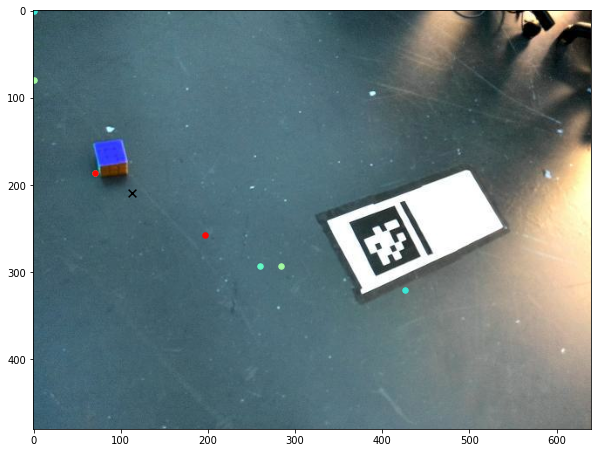

In [177]:
plotTreeOnImage(tree, img)
plt.show()

In [178]:
pxLoc = assemblePxTree(tree)
pick_vec = geometry_pb2.Vec2(x=pxLoc[0], y=pxLoc[1])

grasp = manipulation_api_pb2.PickObjectInImage(
    pixel_xy=pick_vec, transforms_snapshot_for_camera=image_response.shot.transforms_snapshot,
    frame_name_image_sensor=image_response.shot.frame_name_image_sensor,
    camera_model=image_response.source.pinhole)

grasp_request = manipulation_api_pb2.ManipulationApiRequest(pick_object_in_image=grasp)

In [200]:
makeGrasp(grasp_request, graph_nav_client)

Current state:  MANIP_STATE_ATTEMPTING_RAYCASTING
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state: 

Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current st

Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current state:  MANIP_STATE_GRASP_PLANNING_NO_SOLUTION
Current st

KeyboardInterrupt: 

In [159]:
randomLookDir = [((np.random.rand() * 2) - 1) * 2, 
                 (((np.random.rand()) * 2) - 1) * 3, 
                 np.random.rand() * (-2)  ]

In [160]:
moveToAndLookAt([0.8,0,-0.35],randomLookDir, True)

In [181]:
cmd = RobotCommandBuilder.arm_stow_command()
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

In [150]:
cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeout_sec)

In [163]:
bdcrc.blocking_sit(command_client, timeout_sec = timeout_sec)